# Multilayer Perceptron (MLP)

## Libraries

Load the libraries.

In [121]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from imblearn.under_sampling import RandomUnderSampler

## Data Preprocessing

Load the data.

In [122]:
data = pd.read_csv("data/000webhost_subset_classifed_featureExtracted.csv", error_bad_lines=False)

/var/folders/rx/w842_l9s7339g3yr05drhxs40000gn/T/ipykernel_39337/4053744535.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv("data/000webhost_subset_classifed_featureExtracted.csv", error_bad_lines=False)


Split the data into traning and testing sets.

In [132]:
X = data.drop(columns=["password", "strength", "uppercase", "lowercase", "digits", "special", "cracking_time"])
y = data["strength"]

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# First, split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Then, split the training set again to create a validation set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Categorize the output.

In [133]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.fit_transform(y_val)
y_test_encoded = encoder.fit_transform(y_test)

## Model Construction and Evaluation

Build the model.

In [134]:
model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], )),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(3, activation='softmax')
    ]
)

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 512)               4096      
                                                                 
 dropout_78 (Dropout)        (None, 512)               0         
                                                                 
 dense_190 (Dense)           (None, 256)               131328    
                                                                 
 dense_191 (Dense)           (None, 128)               32896     
                                                                 
 dropout_79 (Dropout)        (None, 128)               0         
                                                                 
 dense_192 (Dense)           (None, 64)                8256      
                                                                 
 dense_193 (Dense)           (None, 32)              

Compile and fit the model. 

In [135]:
batch_size = 256
epochs = 100

# Create the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
743/743 [==============================] - 4s 4ms/step - loss: 1.8224 - accuracy: 0.6622 - val_loss: 0.5117 - val_accuracy: 0.7743
Epoch 2/100
743/743 [==============================] - 3s 4ms/step - loss: 0.5125 - accuracy: 0.7673 - val_loss: 0.4962 - val_accuracy: 0.7739
Epoch 3/100
743/743 [==============================] - 3s 4ms/step - loss: 0.4916 - accuracy: 0.7770 - val_loss: 0.4786 - val_accuracy: 0.7819
Epoch 4/100
743/743 [==============================] - 3s 4ms/step - loss: 0.4800 - accuracy: 0.7809 - val_loss: 0.4666 - val_accuracy: 0.7889
Epoch 5/100
743/743 [==============================] - 3s 4ms/step - loss: 0.4719 - accuracy: 0.7850 - val_loss: 0.4611 - val_accuracy: 0.7940
Epoch 6/100
743/743 [==============================] - 3s 4ms/step - loss: 0.4681 - accuracy: 0.7869 - val_loss: 0.4557 - val_accuracy: 0.7978
Epoch 7/100
743/743 [==============================] - 3s 4ms/step - loss: 0.4649 - accuracy: 0.7886 - val_loss: 0.4525 - val_accuracy: 0.7935

Epoch 58/100
743/743 [==============================] - 3s 4ms/step - loss: 0.3372 - accuracy: 0.8690 - val_loss: 0.3324 - val_accuracy: 0.8721
Epoch 59/100
743/743 [==============================] - 4s 5ms/step - loss: 0.3362 - accuracy: 0.8697 - val_loss: 0.3337 - val_accuracy: 0.8702
Epoch 60/100
743/743 [==============================] - 3s 5ms/step - loss: 0.3367 - accuracy: 0.8694 - val_loss: 0.3298 - val_accuracy: 0.8740
Epoch 61/100
743/743 [==============================] - 3s 5ms/step - loss: 0.3384 - accuracy: 0.8685 - val_loss: 0.3266 - val_accuracy: 0.8756
Epoch 62/100
743/743 [==============================] - 3s 5ms/step - loss: 0.3370 - accuracy: 0.8686 - val_loss: 0.3353 - val_accuracy: 0.8727
Epoch 63/100
743/743 [==============================] - 3s 5ms/step - loss: 0.3369 - accuracy: 0.8693 - val_loss: 0.3250 - val_accuracy: 0.8760
Epoch 64/100
743/743 [==============================] - 4s 5ms/step - loss: 0.3352 - accuracy: 0.8694 - val_loss: 0.3274 - val_accuracy:

Run the model on the validation set. 

In [136]:
val_loss, val_acc = model.evaluate(X_val, y_val_encoded)
print(f"Test accuracy: {val_acc:.4f}")

2201/2201 [==============================] - 3s 1ms/step - loss: 0.3282 - accuracy: 0.8747
Test accuracy: 0.8747


Test the model.

In [137]:
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_acc:.4f}")

2201/2201 [==============================] - 3s 1ms/step - loss: 0.3275 - accuracy: 0.8753
Test accuracy: 0.8753


Create a diagram of the model.

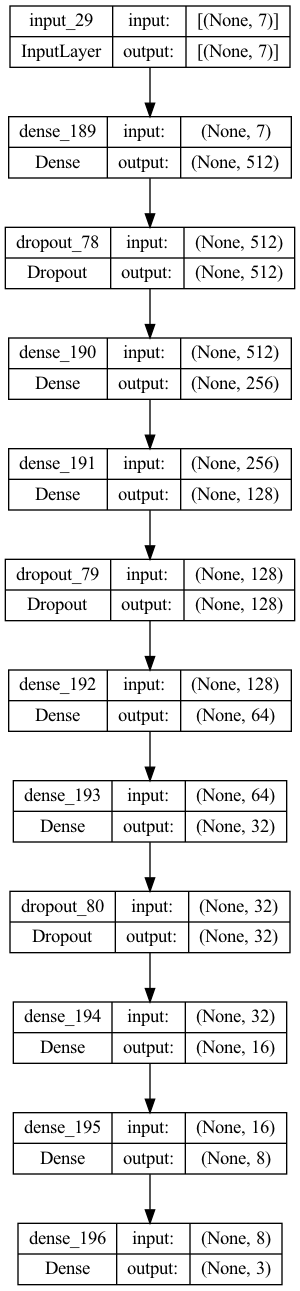

In [138]:
plot_model(model, to_file='MLP.png', show_shapes=True, show_layer_names=True)